In [1]:
import os, sys
import re
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
testname_re = re.compile("test_(\d+)-(\d+).py")

In [3]:
testsuiteNameCache = {}
def getTestsuiteNameFromFile(file):
    global testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/final_project/Volpy_main/")
    s = file.replace("-","/").split("/")
    cur_test = s[-3]+"/"+s[-2]
    with open(file, "r") as f:
        for line in f:
            if line.startswith("###### Description ######"):
                testsuite_name = (f.readline()).strip("#\ \n")
                testsuiteNameCache[cur_test] = testsuite_name
                return testsuite_name
            
def getTestsuiteName(file):
    global testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/final_project/Volpy_main/")
    s = cur_file.replace("-","/").split("/")
    cur_test = s[-3]+"/"+s[-2]
    return testsuiteNameCache[cur_test]

In [4]:
result_file = "result_gcloud.json"
with open(result_file, "r") as f:
    raw_results = json.load(f)

In [5]:
args = type('', (), {})
args.data = "time"

In [6]:
result_dict = {}
for cur_pickle in raw_results["pickleSuites"]:
    result_dict[cur_pickle] = {}
    # First loop to init the dict with testsuite name
    for cur_file in raw_results[cur_pickle]:
        if cur_file.endswith("-1.py"):
            cur_testname = getTestsuiteNameFromFile(cur_file)
            if cur_testname in result_dict[cur_pickle]:
                raise Exception("Impossible flow") # Only one init file should exist.
            result_dict[cur_pickle][cur_testname] = [{} for i in range(2)] # 0/1 for init/test
    # Add the result to our result_dict
    for cur_file in raw_results[cur_pickle]:
        # Get args.data (default: "result") from raw_result
        results = {k: raw_results[cur_pickle][cur_file][k][args.data] if args.data in raw_results[cur_pickle][cur_file][k] else "NA" for k in raw_results[cur_pickle][cur_file]}
        if cur_file.endswith("-1.py"):
            result_dict[cur_pickle][getTestsuiteName(cur_file)][0] = results
        else:
            # There may be several test file
            result_dict[cur_pickle][getTestsuiteName(cur_file)][1].update(results)

In [7]:
# Beauty print with pandas
all_results = {}
for testsuite in result_dict[list(result_dict.keys())[0]]:
    df_all_pickles = []
    for cur_pickle in result_dict:
        df = pd.DataFrame(data=result_dict[cur_pickle][testsuite])
        df = df.fillna(' ').T
        df = df.rename(columns={0: "Init(%s)" % (cur_pickle), 1: "Test(%s)" % (cur_pickle)})
        df_all_pickles.append(df)
    result = pd.concat(df_all_pickles, axis=1)
    all_results[testsuite] = result
#     print(result)
#     result.plot(kind="box")
#     summary_fh.write("===== Testsuite: %s =====\n" % (testsuite))
#     summary_fh.write(str(result))
#     summary_fh.write("\n")

In [8]:
# For exec
exec_testsuiteNameCache = {}
def exec_getTestsuiteNameFromFile(file):
    global exec_testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/final_project/Volpy_main/")
    with open(file, "r") as f:
        for line in f:
            if line.startswith("###### Description ######"):
                testsuite_name = (f.readline()).strip("#\ \n")
                exec_testsuiteNameCache[file] = testsuite_name
                return testsuite_name
            
def exec_getTestsuiteName(file):
    global exec_testsuiteNameCache
    file = file.replace("/home/bankde/", "/Users/bankde/Desktop/project/final_project/Volpy_main/")
    return exec_testsuiteNameCache[file]

In [9]:
# Load from exec results
exec_result_file = "../exec/result_gcloud.json"
with open(exec_result_file, "r") as f:
    exec_raw_results = json.load(f)
cur_pickle = "exec"
exec_result_dict = {}
exec_result_dict[cur_pickle] = {}
# First loop to init the dict with testsuite name
for cur_file in exec_raw_results[cur_pickle]:
    cur_testname = exec_getTestsuiteNameFromFile(cur_file)
    exec_result_dict[cur_pickle][cur_testname] = [{} for i in range(2)] # 0/1 for init/test
# Add the result to our result_dict
for cur_file in exec_raw_results[cur_pickle]:
    # Get args.data (default: "result") from raw_result
    results = {k: exec_raw_results[cur_pickle][cur_file][k][args.data] if args.data in exec_raw_results[cur_pickle][cur_file][k] else "NA" for k in exec_raw_results[cur_pickle][cur_file]}
    # For exec, there should be only Test, no init.
    exec_result_dict[cur_pickle][exec_getTestsuiteName(cur_file)][1] = results
    
exec_all_results = {}
for testsuite in exec_result_dict[list(exec_result_dict.keys())[0]]:
    df_all_pickles = []
    for cur_pickle in exec_result_dict:
        df = pd.DataFrame(data=exec_result_dict[cur_pickle][testsuite])
        df = df.fillna(' ').T
        df = df.rename(columns={0: "Init(%s)" % (cur_pickle), 1: "Test(%s)" % (cur_pickle)})
        df_all_pickles.append(df)
    result = pd.concat(df_all_pickles, axis=1)
    exec_all_results[testsuite] = result

/var/folders/pv/5ntnhsd934q99bbj_55cvf8w0000gn/T/ipykernel_58913/734807423.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


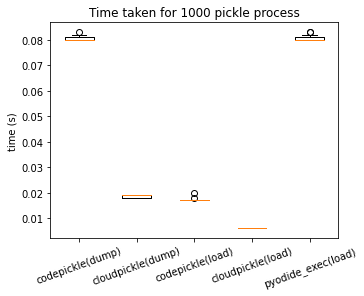

In [13]:
data = []
data.append(all_results["Functions"]["Init(codepickle)"]["test_func_simple"])
data.append(all_results["Functions"]["Init(cloudpickle)"]["test_func_simple"])
data.append(all_results["Functions"]["Test(codepickle)"]["test_func_simple"])
data.append(all_results["Functions"]["Test(cloudpickle)"]["test_func_simple"])
data.append(exec_all_results["Functions"]["Test(exec)"]["test_func_simple"])

fig = plt.figure(figsize =(4, 3))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_title('Time taken for 1000 pickle process')
xtick = ["codepickle(dump)", "cloudpickle(dump)", "codepickle(load)", "cloudpickle(load)", "pyodide_exec(load)"]
ax.set_xticks(range(1,1+len(xtick)), xtick, rotation=20)
ax.set_ylabel('time (s)')
fig.show()

/var/folders/pv/5ntnhsd934q99bbj_55cvf8w0000gn/T/ipykernel_58913/2700514603.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


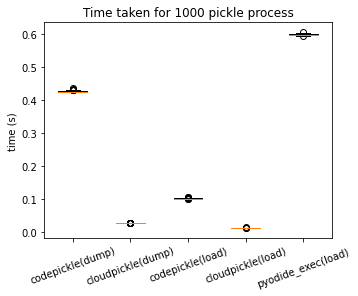

In [14]:
data = []
data.append(all_results["Distributed_sort"]["Init(codepickle)"]["test_distributed_sort"])
data.append(all_results["Distributed_sort"]["Init(cloudpickle)"]["test_distributed_sort"])
data.append(all_results["Distributed_sort"]["Test(codepickle)"]["test_distributed_sort"])
data.append(all_results["Distributed_sort"]["Test(cloudpickle)"]["test_distributed_sort"])
data.append(exec_all_results["Distributed_sort"]["Test(exec)"]["test_distributed_sort"])

fig = plt.figure(figsize =(4, 3))
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
ax.set_title('Time taken for 1000 pickle process')
xtick = ["codepickle(dump)", "cloudpickle(dump)", "codepickle(load)", "cloudpickle(load)", "pyodide_exec(load)"]
ax.set_xticks(range(1,1+len(xtick)), xtick, rotation=20)
ax.set_ylabel('time (s)')
fig.show()